#**Aivle 스쿨 지원 질문, 답변 챗봇 만들기**
# 단계2 : 모델링

## 0.미션

* 다음 세가지 챗봇을 만들고 비교해 봅시다.
* 챗봇1. Word2Vec 임베딩 벡터 기반 머신러닝 분류 모델링
    * Word2Vec 모델을 만들고 임베딩 벡터를 생성합니다.
    * 임베딩 벡터를 이용하여 intent를 분류하는 모델링을 수행합니다.
        * 이때, LightGBM을 추천하지만, 다른 알고리즘을 이용할수 있습니다.
    * 예측된 intent의 답변 중 임의의 하나를 선정하여 출력합니다.
* 챗봇2. 단계별 모델링1
    * 1단계 : type(일상대화 0, 에이블스쿨Q&A 1) 분류 모델 만들기
        * Embedding + LSTM 모델링
    * 2단계 : 사전학습된 Word2Vec 모델을 로딩하여 train의 임베딩벡터 저장
    * 코사인 유사도로 intent 찾아 답변 출력
        * 새로운 문장의 임베딩벡터와 train의 임베딩 벡터간의 코사인 유사도 계산
        * 가장 유사도가 높은 질문의 intent를 찾아 답변 출력하기
* 챗봇3. 단계별 모델링2
    * 1단계 : 챗봇2의 1단계 모델을 그대로 활용
    * 2단계 : FastText 모델 생성하여 train의 임베딩벡터 저장
    * 코사인 유사도로 intent 찾아 답변 출력
        * 새로운 문장의 임베딩벡터와 train의 임베딩 벡터간의 코사인 유사도 계산
        * 가장 유사도가 높은 질문의 intent를 찾아 답변 출력하기

* 챗봇3개에 대해서 몇가지 질문을 입력하고 각각의 답변을 비교해 봅시다.


## 1.환경준비

### (1)라이브러리 설치

#### 1) gensim 3.8.3 설치

In [ ]:
#gensim은 자연어 처리를 위한 오픈소스 라이브러리입니다. 토픽 모델링, 워드 임베딩 등 다양한 자연어 처리 기능을 제공
# 현재 4.x 버전이 최신이지만, 3.8.3 버전으로 진행
!pip install gensim==3.8.3

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


* [코랩] 위 라이브러리 설치후 런타임 재시작 필요!

#### 2) 형태소 분석을 위한 라이브러리

In [ ]:
# mecab 설치를 위한 관련 패키지 설치
!apt-get install curl git
!apt-get install build-essential
!apt-get install cmake
!apt-get install g++
!apt-get install flex
!apt-get install bison
!apt-get install python-dev
!pip install cython
!pip install mecab-python

Reading package lists... Done
Building dependency tree       
Reading state information... Done
curl is already the newest version (7.68.0-1ubuntu2.18).
git is already the newest version (1:2.25.1-1ubuntu3.10).
0 upgraded, 0 newly installed, 0 to remove and 24 not upgraded.
Reading package lists... Done
Building dependency tree       
Reading state information... Done
build-essential is already the newest version (12.8ubuntu1.1).
0 upgraded, 0 newly installed, 0 to remove and 24 not upgraded.
Reading package lists... Done
Building dependency tree       
Reading state information... Done
cmake is already the newest version (3.16.3-1ubuntu1.20.04.1).
0 upgraded, 0 newly installed, 0 to remove and 24 not upgraded.
Reading package lists... Done
Building dependency tree       
Reading state information... Done
g++ is already the newest version (4:9.3.0-1ubuntu2).
0 upgraded, 0 newly installed, 0 to remove and 24 not upgraded.
Reading package lists... Done
Building dependency tree       
Rea

In [ ]:
# 형태소 기반 토크나이징 (Konlpy)
!python3 -m pip install konlpy
# mecab (ubuntu: linux, mac os 기준)
# 다른 os 설치 방법 및 자세한 내용은 다음 참고: https://konlpy.org/ko/latest/install/#id1
!bash <(curl -s https://raw.githubusercontent.com/konlpy/konlpy/master/scripts/mecab.sh)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
mecab-ko is already installed
mecab-ko-dic is already installed
mecab-python is already installed
Done.


### (2) 라이브러리 불러오기

* 세부 요구사항
    - 기본적으로 필요한 라이브러리를 import 하도록 코드가 작성되어 있습니다.
    - 필요하다고 판단되는 라이브러리를 추가하세요.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

# 필요하다고 판단되는 라이브러리를 추가하세요.
import os

from sklearn.model_selection import train_test_split
from lightgbm import LGBMClassifier
from sklearn.metrics import * 

import tensorflow as tf
from keras.layers import Dense, Embedding, Bidirectional, LSTM, Concatenate, Dropout
from keras import Input, Model
from keras import optimizers
from keras.models import Sequential, load_model
from keras.callbacks import EarlyStopping, ModelCheckpoint

from gensim.models import Word2Vec
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

from sklearn.metrics.pairwise import cosine_similarity

* 형태소 분석을 위한 함수를 제공합니다.

In [ ]:
from konlpy.tag import Okt, Komoran, Mecab, Hannanum, Kkma

# 다양한 토크나이저를 사용할 수 있는 함수
def get_tokenizer(tokenizer_name):
    if tokenizer_name == "komoran":
        tokenizer = Komoran()
    elif tokenizer_name == "okt":
        tokenizer = Okt()
    elif tokenizer_name == "mecab":
        tokenizer = Mecab()
    elif tokenizer_name == "hannanum":
        tokenizer = Hannanum()
    else:
        # "kkma":
        tokenizer = Kkma()
        
    return tokenizer

In [ ]:
# 형태소 분석을 수행하는 함수
def tokenize(tokenizer_name, original_sent, nouns=False):
    # 미리 정의된 몇 가지 tokenizer 중 하나를 선택
    tokenizer = get_tokenizer(tokenizer_name)

    # tokenizer를 이용하여 original_sent를 토큰화하여 tokenized_sent에 저장하고, 이를 반환합니다.
    sentence = original_sent.replace('\n', '').strip()
    if nouns:       
        # tokenizer.nouns(sentence) -> 명사만 추출
        tokens = tokenizer.nouns(sentence)
    else:
        tokens = tokenizer.morphs(sentence)
    tokenized_sent = ' '.join(tokens)
    
    return tokenized_sent

* Word2Vec 모델로부터 데이터를 벡터화하기 위한 함수 생성

In [ ]:
# Word2Vec 모델로부터 하나의 문장을 벡터화 시키는 함수
def get_sent_embedding(model, embedding_size, tokenized_words):
    feature_vec = np.zeros((embedding_size,), dtype='float32')  # 임베딩 벡터를 0으로 초기화
    n_words = 0  # 단어 개수 초기화
    index2word_set = set(model.wv.index2word)  # 모델 단어 집합 생성

    for word in tokenized_words:  # 문장의 단어들을 하나씩 반복
        if word in index2word_set:  # 모델 단어 집합에 해당하는 단어일 경우에만
            n_words += 1  # 단어 개수 1 증가
            feature_vec = np.add(feature_vec, model[word])   # 임베딩 벡터에 해당 단어의 벡터를 더함
            
    if (n_words > 0):  # 단어 개수가 0보다 큰 경우
        feature_vec = np.divide(feature_vec, n_words)  # 벡터를 단어 개수로 나눠줌 (평균 임베딩 벡터 계산)

    return feature_vec

In [ ]:
# 문장벡터 데이터 셋 만들기
def get_dataset(sentences, model, num_features):
    dataset = list()

    # 각 문장을 벡터화해서 리스트에 저장
    for sent in sentences:
        dataset.append(get_sent_embedding(model, num_features, sent))

    # 리스트를 numpy 배열로 변환하여 반환
    sent_embedding_vectors = np.stack(dataset)
    
    return sent_embedding_vectors

### (3) 데이터 로딩
* 전처리 단계에서 생성한 데이터들을 로딩합니다.
    * train, test
    * 형태소분석 결과 데이터 : clean_train_questions, clean_test_questions

* 구글 드라이브 연결

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


* 저장된 .pkl 파일들을 불러옵니다.
* 불러 온 후에는 shape를 확인해 봅시다.

In [ ]:
import joblib

train_data = joblib.load('/content/drive/MyDrive/16 Mini Project06/train_data.pkl')
test_data = joblib.load('/content/drive/MyDrive/16 Mini Project06/test_data.pkl')
clean_train_questions = joblib.load('/content/drive/MyDrive/16 Mini Project06/clean_train_questions.pkl')
clean_test_questions = joblib.load('/content/drive/MyDrive/16 Mini Project06/clean_test_questions.pkl')

In [ ]:
train_data.shape, test_data.shape, clean_train_questions.shape, clean_test_questions.shape

((1116, 5), (106, 5), (1116,), (106,))

## 2.챗봇1

* **상세요구사항**
    * Word2Vec을 활용한 LightGBM 모델링(intent 분류)
        * Word2Vec을 이용하여 임베딩벡터 생성하기
            * Word Embedding으로 문장벡터 구하기
        * 임베딩 벡터를 이용하여 ML기반 모델링 수행하기
            * LightGBM 권장(다른 알고리즘을 이용할수 있습니다.)
    * 챗봇 : 모델의 예측결과(intent)에 따라 답변하는 챗봇 만들기
        * 질문을 입력받아, 답변하는 함수 생성

### (1) Word2Vec을 이용하여 임베딩벡터 생성하기
* 'mecab' 형태소 분석기를 이용하여 문장을 tokenize
    * Word2Vec 모델을 만들기 위해서 입력 데이터는 리스트 형태여야 합니다.
    * 그래서 다시 리스트로 저장되도록 토크나이즈 해 봅시다.
* Word Embedding으로 문장벡터를 생성합니다.
    * 먼저 Word2Vec 모델을 만들고, train의 질문들을 문장벡터로 만듭시다.


#### 1) 'mecab' 형태소 분석기를 이용하여 문장을 tokenize

In [ ]:
mecab_tokenize_li = []
for i, d in train_data.iterrows():
    temp = tokenize('mecab', d['Q']).split()
    mecab_tokenize_li.append(temp)

#### 2) Word Embedding으로 문장벡터 구하기
* Word2Vec
    * 위에서 저장한 입력 데이터를 사용하여 Word2Vec 모델이 생성
    * 모델은 size(단어 벡터의 차원), 
    * window(컨텍스트 창의 크기), 
    * max_vocab_size(고려할 최대 어휘 크기), 
    * min_count(포함할 단어의 최소 빈도)와 같은 특정 하이퍼파라미터로 훈련됩니다.
    * sg : 사용할 훈련 알고리즘 - 1은 skip-gram, 0은 CBOW )

In [ ]:
from gensim.models import Word2Vec

# Word2Vec 모델 생성
wv_model = Word2Vec(mecab_tokenize_li,
                    size=100,  # 벡터의 차원
                    window=5,  # 훈련 시 앞뒤로 고려하는 단어의 개수
                    min_count=0,  # 최소 빈도수
                    sg=1)  # 1(skip-gram) : 중간의 단어로 주변 단어 예측 / 0(CBOW) : 주변의 단어로 중간의 단어 예측

:* Word2Vec 모델로부터 데이터를 벡터화하기 위한 함수 생성

In [ ]:
# Word2Vec 모델로부터 하나의 문장을 벡터화 시키는 함수
def get_sent_embedding(model, embedding_size, tokenized_words):
    feature_vec = np.zeros((embedding_size,), dtype='float32')  # 임베딩 벡터를 0으로 초기화
    n_words = 0  # 단어 개수 초기화
    index2word_set = set(model.wv.index2word)  # 모델 단어 집합 생성

    for word in tokenized_words:  # 문장의 단어들을 하나씩 반복
        if word in index2word_set:  # 모델 단어 집합에 해당하는 단어일 경우에만
            n_words += 1  # 단어 개수 1 증가
            feature_vec = np.add(feature_vec, model[word])   # 임베딩 벡터에 해당 단어의 벡터를 더함
            
    if (n_words > 0):  # 단어 개수가 0보다 큰 경우
        feature_vec = np.divide(feature_vec, n_words)  # 벡터를 단어 개수로 나눠줌 (평균 임베딩 벡터 계산)

    return feature_vec

In [ ]:
# 문장벡터 데이터 셋 만들기
def get_dataset(sentences, model, num_features):
    dataset = list()

    # 각 문장을 벡터화해서 리스트에 저장
    for sent in sentences:
        dataset.append(get_sent_embedding(model, num_features, sent))

    # 리스트를 numpy 배열로 변환하여 반환
    sent_embedding_vectors = np.stack(dataset)
    
    return sent_embedding_vectors

* 이제 학습데이터의 Q를 Word2Vec 모델을 사용하여 벡터화 합니다.

In [ ]:
train_data.shape

(1116, 5)

In [ ]:
# 학습 데이터의 문장들을 Word2Vec 모델을 사용하여 벡터화
train_data_vecs = get_dataset(train_data['Q'], wv_model, 100)

* 훈련된 Word2Vec 모델을 사용하여 문장 목록에 대한 문장 임베딩을 생성하고 이를 2차원 numpy 배열에 저장합니다. 
* 그런 다음 이러한 임베딩을 다양한 기계 학습 모델의 입력 기능으로 사용할 수 있습니다

### (2) 분류 모델링
* 데이터 분할
    * x, y
        * x : 이전 단계에서 저장된 임베딩벡터(train_data_vecs)
        * y : intent 값들
    * train, val
        * train_test_split 활용
* 머신러닝 모델링
    * lightGBM, RandomForest 등을 활용하여 학습
    * 필요하다면 hyper parameter 튜닝을 시도해도 좋습니다.
* validation set으로 검증해 봅시다.

In [ ]:
# X와 y 데이터 분리
target = 'intent'
x = train_data_vecs
y = train_data.loc[:, target]

# Train-Test split
from sklearn.model_selection import train_test_split
x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.2, random_state=42)

* 모델1

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

model_rfc = RandomForestClassifier()
model_rfc.fit(x_train, y_train)

RandomForestClassifier()

In [ ]:
pred_rfc = model_rfc.predict(x_val)
print(accuracy_score(pred_rfc, y_val))

0.33482142857142855


* 모델2

In [ ]:
from lightgbm import LGBMClassifier
from sklearn.metrics import accuracy_score

model_lgbm = LGBMClassifier(max_depth=20, )
model_lgbm.fit(x_train, y_train)

LGBMClassifier(max_depth=20)

In [ ]:
pred_lgbm = model_lgbm.predict(x_val)
print(accuracy_score(pred_lgbm, y_val))

0.35714285714285715


* 모델3

In [ ]:
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import accuracy_score

rfc = RandomForestClassifier()
lgbm = LGBMClassifier()
estimators=[('rfc', rfc), ('lgbm', lgbm)]
stacking = StackingClassifier(estimators=estimators)
stacking.fit(x_train, y_train)

/usr/local/lib/python3.9/dist-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(


StackingClassifier(estimators=[('rfc', RandomForestClassifier()),
                               ('lgbm', LGBMClassifier())])

In [ ]:
pred_stacking = stacking.predict(x_val)
print(accuracy_score(pred_stacking, y_val))

0.3125


### (3) 챗봇 구축

* **상세요구사항**
    * 챗봇 flow : input 질문 -> 분류 모델로 intent 예측 --> intent에 해당하는 답변 출력
        * 하나의 intent 에는 여러 답변이 있습니다. 이중 한가지를 랜덤하게 선택합니다.

#### 1) 데이터 중 하나에 대해서 테스트

In [ ]:
# input 질문
input = ['노트북 전원이 안들어와요']

In [ ]:
# Word2Vec 모델을 사용하여 벡터화
input_vecs = get_dataset(input, wv_model, 100) 

# 분류 모델로 intent 예측
intent_pred = model_lgbm.predict(input_vecs)

In [ ]:
# intent에 해당하는 답변 출력
answer = train_data.loc[train_data['intent'] == intent_pred[0]].sample(n=1)['A'].values[0]
print(answer)

고민이 많은가 봐요.


#### 2) 챗봇 함수 만들기
* 테스트 코드를 바탕으로 질문을 받아 답변을 하는 함수를 생성합시다.
* 성능이 좋은 모델 사용. 

In [ ]:
def get_answer1(question): 
    # 분류 모델로 intent 예측
    input_vecs = get_dataset(input, wv_model, 100)  # Word2Vec 모델을 사용하여 벡터화
    intent_pred = model_lgbm.predict(input_vecs)

    # intent에 해당하는 답변 출력
    answer = train_data.loc[train_data['intent'] == intent_pred[0]].sample(n=1)['A'].values[0]

    return answer

#### 3) test 데이터에 대해서 성능 측정하기

test 데이터 전체에 대해서 성능을 측정해 봅시다.

## 3.챗봇2

* **세부요구사항**
    * 단계별 챗봇을 만들어 봅시다.
        * 1단계 : type을 0과 1로 분류하는 모델 생성(Embedding + LSTM 모델)
        * 2단계 : 
            * 각 type에 맞게, 사전학습된 Word2Vec 모델을 사용하여 임베딩 벡터(train)를 만들고
        * 3단계 : 챗봇 만들기
            * input 문장과 train 임베딩 벡터와 코사인 유사도 계산
            * 가장 유사도가 높은 질문의 intent 찾아
            * 해당 intent의 답변 중 무작위로 하나를 선정하여 답변하기

### (1) 1단계 : type 분류 모델링(LSTM)
- LSTM

#### 1) 데이터 준비
* 학습용 데이터를 만들어 봅시다.
    * 시작 데이터 : clean_train_questions, clean_test_questions
    * 각 토큰에 인덱스를 부여하는 토크나이저를 만들고 적용
        * from tensorflow.keras.preprocessing.text import Tokenizer 를 사용
    * 문장별 길이에 대한 분포를 확인하고 적절하게 정의.

In [ ]:
# 각각의 토큰에 인덱스 부여하는 토크나이저 선언
from tensorflow.keras.preprocessing.text import Tokenizer

# .fit_on_tests 이용하여 토크나이저 만들기
tokenizer = Tokenizer()
tokenizer.fit_on_texts(clean_train_questions)

In [ ]:
# 전체 토큰의 수 확인
len(tokenizer.word_index)

1132

In [ ]:
# 전체 토큰의 수로 vocab_size 지정
vocab_size = len(tokenizer.word_index)

# fit_on_texts을 위에서 한번만 해도 되지만, vocab 사이즈를 확인하고 줄이거나 하는 시도를 할 수도 있기에 다시 수행
tokenizer.fit_on_texts(clean_train_questions)

# .texts_to_sequences : 토크나이즈 된 데이터를 가지고 모두 시퀀스로 변환
x_train = tokenizer.texts_to_sequences(clean_train_questions)
x_val = tokenizer.texts_to_sequences(clean_test_questions)

In [ ]:
# 각 토큰과 인덱스로 구성된 딕셔너리 생성,

# <PAD> 는 0으로 추가


* 문장별 토큰수에 대해 탐색적 분석을 수행해 봅시다.

In [ ]:
x_train_token_len = [len(x) for x in x_train]

<BarContainer object of 1116 artists>

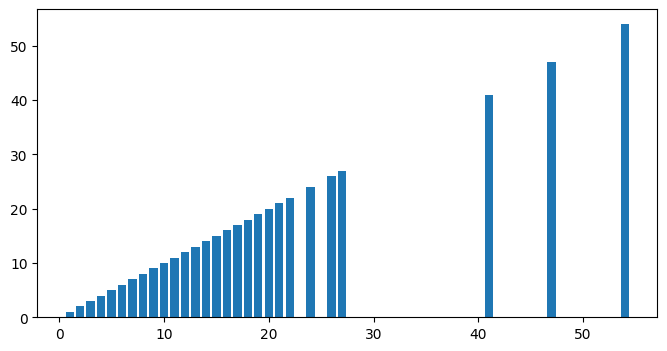

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 4))
plt.bar(x_train_token_len, x_train_token_len)

In [ ]:
max(x_train_token_len)

54

* 학습 입력을 위한 데이터 크기 맞추기
    * 문장이 짧기 때문에 MAX_SEQUENCE_LENGTH는 정하지 않아도 되지만,
    * 그러나 분포를 보고 적절하게 자릅시다.
    * 그리고 pad_sequences 함수를 이용하여 시퀀스데이터로 변환하기
* y는 train['type'] 와 test['type'] 입니다.

In [ ]:
embedding_dim = 128
max_len = 54
max_words = 2000

In [ ]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

x_train = pad_sequences(x_train, maxlen=max_len)
x_val = pad_sequences(x_val, maxlen=max_len)

y_train = train_data['type']
y_val = test_data['type']

In [ ]:
x_val

array([[  0,   0,   0, ...,  51,  12, 108],
       [  0,   0,   0, ..., 125,  51, 313],
       [  0,   0,   0, ...,  19,  42,  13],
       ...,
       [  0,   0,   0, ...,   2,   3, 251],
       [  0,   0,   0, ..., 105,   4, 669],
       [  0,   0,   0, ..., 105,   4, 669]], dtype=int32)

#### 2) 모델링

* 토크나이징 한 데이터를 입력으로 받아 
* Embedding 레이어와 LSTM 레이어를 결합하여 이진 분류 모델링을 수행합니다.

In [ ]:
x_train.shape, y_train.shape

In [ ]:
import tensorflow as tf
from tensorflow import keras

from tensorflow.keras import backend
from tensorflow.keras.layers import Input, LSTM, GRU, SimpleRNN, Flatten, Dense
from tensorflow.keras.layers import Embedding, Bidirectional, Conv1D, MaxPool1D
from tensorflow.keras.models import Sequential

from sklearn.metrics import classification_report, f1_score

In [ ]:
# 1. 세션 클리어
backend.clear_session()

# 2. 모델 선언
model_lstm = Sequential()

# 3. 레이어 조립
model_lstm.add(Embedding(max_words, 128, input_length=max_len))

model_lstm.add(LSTM(64, return_sequences=True))
model_lstm.add(Flatten())
model_lstm.add(Dense(512, activation='relu'))
model_lstm.add(Dense(1, activation='sigmoid'))

# 4. 컴파일
model_lstm.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model_lstm.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 54, 128)           256000    
                                                                 
 lstm (LSTM)                 (None, 54, 64)            49408     
                                                                 
 flatten (Flatten)           (None, 3456)              0         
                                                                 
 dense (Dense)               (None, 512)               1769984   
                                                                 
 dense_1 (Dense)             (None, 1)                 513       
                                                                 
Total params: 2,075,905
Trainable params: 2,075,905
Non-trainable params: 0
_________________________________________________________________


In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

es = EarlyStopping(monitor='val_loss',
                   min_delta=0,
                   patience=10,
                   verbose=1)

In [ ]:
model_lstm.fit(x_train, y_train,
               epochs=1000,
               batch_size=128,
               validation_split=0.2,
               verbose=1,
               callbacks=[es])

Epoch 1/1000
7/7 [==============================] - 3s 196ms/step - loss: 0.6669 - accuracy: 0.6704 - val_loss: 0.5174 - val_accuracy: 0.9777
Epoch 2/1000
7/7 [==============================] - 1s 110ms/step - loss: 0.4818 - accuracy: 0.8184 - val_loss: 0.4885 - val_accuracy: 0.7232
Epoch 3/1000
7/7 [==============================] - 1s 117ms/step - loss: 0.2596 - accuracy: 0.8957 - val_loss: 0.4479 - val_accuracy: 0.7902
Epoch 4/1000
7/7 [==============================] - 1s 179ms/step - loss: 0.1314 - accuracy: 0.9496 - val_loss: 0.2449 - val_accuracy: 0.8884
Epoch 5/1000
7/7 [==============================] - 1s 171ms/step - loss: 0.0435 - accuracy: 0.9888 - val_loss: 0.3002 - val_accuracy: 0.8795
Epoch 6/1000
7/7 [==============================] - 1s 111ms/step - loss: 0.0153 - accuracy: 0.9978 - val_loss: 0.1908 - val_accuracy: 0.8973
Epoch 7/1000
7/7 [==============================] - 1s 113ms/step - loss: 0.0061 - accuracy: 0.9989 - val_loss: 0.2304 - val_accuracy: 0.8884
Epoch 

In [ ]:
# 예측
y_pred_lstm = model_lstm.predict(x_val)
y_pred_lstm = np.where(y_pred_lstm > 0.5, 1, 0)
# 딥러닝의 예측값은 0~1 사이의 확률 값이 나옴.
# 따라서 classification_report를 하기 위해서는 확률에 따라 0과 1로 변환해주어야 함.

# 평가
print(classification_report(y_val, y_pred_lstm))
print(f1_score(y_val, y_pred_lstm))

### (2) 사전학습모델(Word2Vec)

* Pre-trained Word2Vec model
    * 이미 다운로드 받아서 제공되었습니다.
        * ko.bin, ko.tsv
    * 참고 사이트: https://github.com/Kyubyong/wordvectors
        * 모델 파일 다운로드 사이트: https://drive.google.com/file/d/0B0ZXk88koS2KbDhXdWg1Q2RydlU/view?resourcekey=0-Dq9yyzwZxAqT3J02qvnFwg
* 사전학습 모델을 로딩하고, 
* train 데이터셋의 질문(Q)을 임베딩벡터로 만들어, 열(Column)로 추가합니다.

#### 1) 모델 로딩
* 사전 학습된 모델을 로딩 : gensim.models.Word2Vec.load()
* 로딩 후 벡터 크기를 조회합시다. .vector_size

In [ ]:
import gensim
pre_wv_model = gensim.models.Word2Vec.load('/content/drive/MyDrive/16 Mini Project06/ko/ko.bin')

In [ ]:
# 모델의 벡터크기 조회
pre_wv_model.vector_size

200

#### 2) train 에 임베딩벡터 결과 저장
* get_sent_embedding 함수를 이용하여 train의 질문별 임베딩 결과를 저장합니다.
    * .apply(lambda .....) 를 활용하세요.

In [ ]:
train_data['Embdedding'] = train_data['Q'].apply(lambda sent : get_sent_embedding(pre_wv_model, pre_wv_model.vector_size, sent))

### (3) 챗봇 구축
* 아래 절차대로 수행하는 함수 만들기
    * input 질문 
    * 1단계 : 모델을 이용하여 type 0, 1로 분류
    * 2단계 : 
        * train의 모든 Q와 input 문장의 임베딩 벡터간의 코사인 유사도 계산
        * 코사인 유사도가 가장 높은 Q를 선택
        * 선택한 Q의 intent에 맵핑된 답변 중 하나를 무작위로 선택

In [ ]:
embedding_dim = 128
max_len = 54
max_words = 2000

In [ ]:
import gensim
pre_wv_model = gensim.models.Word2Vec.load('/content/drive/MyDrive/16 Mini Project06/ko/ko.bin')

In [ ]:
# 각각의 토큰에 인덱스 부여하는 토크나이저 선언
from tensorflow.keras.preprocessing.text import Tokenizer

# .fit_on_tests 이용하여 토크나이저 만들기
tokenizer = Tokenizer()
tokenizer.fit_on_texts(clean_train_questions)

# 전체 토큰의 수로 vocab_size 지정
vocab_size = len(tokenizer.word_index)

# fit_on_texts을 위에서 한번만 해도 되지만, vocab 사이즈를 확인하고 줄이거나 하는 시도를 할 수도 있기에 다시 수행
tokenizer.fit_on_texts(clean_train_questions)

# .texts_to_sequences : 토크나이즈 된 데이터를 가지고 모두 시퀀스로 변환
x_train = tokenizer.texts_to_sequences(clean_train_questions)
x_val = tokenizer.texts_to_sequences(clean_test_questions)

from tensorflow.keras.preprocessing.sequence import pad_sequences

x_train = pad_sequences(x_train, maxlen=max_len)
x_val = pad_sequences(x_val, maxlen=max_len)

y_train = train_data['type']
y_val = test_data['type']

In [ ]:
import tensorflow as tf
from tensorflow import keras

from tensorflow.keras import backend
from tensorflow.keras.layers import Input, LSTM, GRU, SimpleRNN, Flatten, Dense
from tensorflow.keras.layers import Embedding, Bidirectional, Conv1D, MaxPool1D
from tensorflow.keras.models import Sequential

from sklearn.metrics import classification_report, f1_score

# 1. 세션 클리어
backend.clear_session()

# 2. 모델 선언
model_lstm = Sequential()

# 3. 레이어 조립
model_lstm.add(Embedding(max_words, 128, input_length=max_len))

model_lstm.add(LSTM(64, return_sequences=True))
model_lstm.add(Flatten())
model_lstm.add(Dense(512, activation='relu'))
model_lstm.add(Dense(1, activation='sigmoid'))

# 4. 컴파일
model_lstm.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model_lstm.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 54, 128)           256000    
                                                                 
 lstm (LSTM)                 (None, 54, 64)            49408     
                                                                 
 flatten (Flatten)           (None, 3456)              0         
                                                                 
 dense (Dense)               (None, 512)               1769984   
                                                                 
 dense_1 (Dense)             (None, 1)                 513       
                                                                 
Total params: 2,075,905
Trainable params: 2,075,905
Non-trainable params: 0
_________________________________________________________________


In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

es = EarlyStopping(monitor='val_loss',
                   min_delta=0,
                   patience=10,
                   verbose=1)

model_lstm.fit(x_train, y_train,
               epochs=1000,
               batch_size=128,
               validation_split=0.2,
               verbose=1,
               callbacks=[es])

Epoch 1/1000
7/7 [==============================] - 4s 197ms/step - loss: 0.6912 - accuracy: 0.5516 - val_loss: 0.7476 - val_accuracy: 0.2009
Epoch 2/1000
7/7 [==============================] - 1s 109ms/step - loss: 0.5866 - accuracy: 0.8520 - val_loss: 0.5056 - val_accuracy: 0.7812
Epoch 3/1000
7/7 [==============================] - 1s 110ms/step - loss: 0.3349 - accuracy: 0.9159 - val_loss: 0.3956 - val_accuracy: 0.7768
Epoch 4/1000
7/7 [==============================] - 1s 110ms/step - loss: 0.1385 - accuracy: 0.9484 - val_loss: 0.3255 - val_accuracy: 0.8438
Epoch 5/1000
7/7 [==============================] - 1s 171ms/step - loss: 0.0601 - accuracy: 0.9742 - val_loss: 0.4772 - val_accuracy: 0.8304
Epoch 6/1000
7/7 [==============================] - 1s 167ms/step - loss: 0.0200 - accuracy: 0.9955 - val_loss: 0.1193 - val_accuracy: 0.9330
Epoch 7/1000
7/7 [==============================] - 1s 129ms/step - loss: 0.0055 - accuracy: 0.9978 - val_loss: 0.3361 - val_accuracy: 0.8616
Epoch 

In [ ]:
train_data['Embdedding'] = train_data['Q'].apply(lambda sent : get_sent_embedding(pre_wv_model, pre_wv_model.vector_size, sent))

In [ ]:
train_data

,intent,Q,A,type,Q_len,Embdedding
0,1,떨어뜨려서 핸드폰 액정 나갔어,as 맡기세요.,0,16,"[0.13196047, 0.32847217, -0.06884714, -0.28933..."
1,1,액정 나갔어,as 맡기세요.,0,6,"[0.9977055, 0.18345009, 0.5321375, 0.15335676,..."
2,1,핸드폰 떨어뜨려서 고장 났나봐,as 맡기세요.,0,16,"[-0.107691675, 0.26600096, -0.07888139, -0.242..."
3,1,노트북 키보드가 안먹히네,AS센터에 맡겨보세요.,0,13,"[0.8356018, -0.9253282, 0.6200317, -0.1324172,..."
4,1,노트북 전원이 안들어와.,AS센터에 맡겨보세요.,0,13,"[0.08162771, 0.1425681, 0.5024069, -0.38977492..."
...,...,...,...,...,...,...
1111,53,KT 에이블스쿨만의 장점이 무엇인지 상세히 설명해주세요,KT 에이블스쿨에서는 이론/실습 교육에 나아가 기업 실전형 프로젝트를 중심으로 실무...,1,30,"[0.39918602, -0.8197436, 0.32995123, -0.219605..."
1112,53,다른 교육과의 차이점은 무엇인가요?,KT 에이블스쿨에서는 이론/실습 교육에 나아가 기업 실전형 프로젝트를 중심으로 실무...,1,19,"[0.2581207, -0.49135607, 0.15457197, -0.082854..."
1113,53,다른 교육과 차이점이 있나요?,KT 에이블스쿨에서는 이론/실습 교육에 나아가 기업 실전형 프로젝트를 중심으로 실무...,1,16,"[0.45885175, -0.36211675, 0.029572647, -0.2195..."
1114,53,다른 국비 지원 교육보다 특별한 점이 있는지 궁금해요,KT 에이블스쿨에서는 이론/실습 교육에 나아가 기업 실전형 프로젝트를 중심으로 실무...,1,29,"[0.7093675, -0.5006321, -0.4346299, -0.0964832..."


#### 1) 하나의 질문으로 테스트해보기

* 선택된 질문과 답변

In [ ]:
input = '원하던 대학교에 합격했어'

* 예측을 위한 입력 형태로 변환
    * 학습을 위한 전처리 과정을 test 데이터에도 적용합니다. 

In [ ]:
input_tk = tokenize('mecab', input)
input_tk

'원 하 던 대학교 에 합격 했 어'

In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

tokenizer = Tokenizer()
tokenizer.fit_on_texts(clean_train_questions)

input_seq = tokenizer.texts_to_sequences([input_tk])
input_seq = pad_sequences(input_seq, maxlen=max_len)
input_seq

array([[  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0, 199,   6, 615, 245,  10,  70,
         71,  13]], dtype=int32)

* 1단계 : type 분류

In [ ]:
type_pred = model_lstm.predict(input_seq)
type_pred = np.where(type_pred > 0.5, 1, 0)
type_pred

1/1 [==============================] - 0s 22ms/step


array([[0]])

* 2단계 : 질문에 대한 벡터 만들고 코사인 유사도 계산
    * Word2Vec 사전 학습 모델로 부터 벡터 만들기

In [ ]:
embedding_vec = get_sent_embedding(pre_wv_model, pre_wv_model.vector_size, input_tk)
embedding_vec = [list(embedding_vec)]

* train의 질문 벡터들과 유사도 계산
    * Word2Vec 으로 만든 벡터들과 유사도 계산

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity

intent_temp = train_data.loc[train_data['type'] == type_pred[0][0]].copy()
intent_temp['cosine_similarity'] = intent_temp['Embdedding'].apply(lambda e : max(cosine_similarity(embedding_vec, [list(e)])))
intent_temp['cosine_similarity'] = intent_temp['cosine_similarity'].astype('int')
max_idx = intent_temp['cosine_similarity'].idxmax()
intent_temp['A'][max_idx]

'as 맡기세요.'

#### 2) 챗봇 함수 만들기
* 위 테스트 결과를 바탕으로 코드를 정리하고 함수로 생성합니다.

In [ ]:
def get_answer2(question): 
    input = tokenize('mecab', question)

    input_seq = tokenizer.texts_to_sequences([input])
    input_seq = pad_sequences(input_seq, maxlen=max_len)

    # type 분류
    type_pred = model_lstm.predict(input_seq)
    type_pred = np.where(type_pred > 0.5, 1, 0)

    # 질문에 대한 코사인 유사도 계산
    embedding_vec = get_sent_embedding(pre_wv_model, pre_wv_model.vector_size, input)
    embedding_vec = [list(embedding_vec)]

    # 벡터들과 유사도 계산
    intent_temp = train_data.loc[train_data['type'] == type_pred[0][0]].copy()
    intent_temp['cosine_similarity'] = intent_temp['Embdedding'].apply(lambda e : max(cosine_similarity(embedding_vec, [list(e)])[0]))
    max_idx = intent_temp['cosine_similarity'].idxmax()

    return intent_temp['A'][max_idx]

#### 3) test 데이터에 대해서 성능 측정하기

test 데이터 전체에 대해서 성능을 측정해 봅시다.

In [ ]:
test = test_data.copy()
test['pred_A'] = test['Q'].apply(lambda q : get_answer2(q))

1/1 [==============================] - 0s 23ms/step


In [ ]:
test.head()

,intent,Q,A,type,Q_len,pred_A
0,1,노트북이 작동이 안되네,AS센터에 맡겨보세요.,0,12,AS센터에 맡겨보세요.
1,1,핸드폰 안돼,AS센터에 맡겨보세요.,0,6,AS센터에 맡겨보세요.
2,2,여자친구를 사귀고 싶어,가장 중요한 목표네요.,0,12,제가 있잖아요.
3,2,건강이 최고인 것 같아,가장 중요한 목표네요.,0,12,가장 중요한 목표네요.
4,3,얼어죽는 줄 알았어,감기 조심하세요.,0,10,감기 조심하세요.


In [ ]:
test.tail()

,intent,Q,A,type,Q_len,pred_A
101,51,혜택사항이 있나요?,"네, 취업에 도움이 되는 다양한 프로젝트를 제공하고, 포트폴리오 작성을 도와드리며,...",1,10,"취업에 도움이 되는 다양한 프로젝트를 제공하고, 포트폴리오 작성을 도와드리며, 코딩..."
102,52,대면 교육 시 별도로 교통비나 숙박비를 지원해주나요?,숙소 및 기숙사에 대한 지원은 제공하지 않습니다.,1,29,"KT 에이블스쿨은 풀타임(09:00~18:00)으로 교육이 진행되며, 정해진 시간에..."
103,52,숙소나 기숙사 이용료는 어떻게 결제하나요? 할인 혜택이 있는가요?,숙소 및 기숙사에 대한 지원은 제공하지 않습니다.,1,36,숙소 및 기숙사에 대한 지원은 제공하지 않습니다.
104,53,다른 국비지원 교육과 뭐가 다른가요?,KT 에이블스쿨에서는 이론/실습 교육에 나아가 기업 실전형 프로젝트를 중심으로 실무...,1,20,KT 에이블스쿨에서는 이론/실습 교육에 나아가 기업 실전형 프로젝트를 중심으로 실무...
105,53,국비지원 IT 교육이 많은데 똑같은 거 아닌가요?\n뭐가 다른가요?,KT 에이블스쿨에서는 이론/실습 교육에 나아가 기업 실전형 프로젝트를 중심으로 실무...,1,36,KT 에이블스쿨에서는 이론/실습 교육에 나아가 기업 실전형 프로젝트를 중심으로 실무...


## 4.챗봇3

* **세부요구사항**
    * 단계별 챗봇을 만들어 봅시다.
        * 1단계 : 챗봇2의 1단계 모델을 사용합니다.
        * 2단계 : 
            * 각 type에 맞게, 사전학습된 Word2Vec 모델을 사용하여 임베딩 벡터(train)를 만들고
        * 3단계 : 챗봇 만들기
            * input 문장과 train 임베딩 벡터와 코사인 유사도 계산
            * 가장 유사도가 높은 질문의 intent 찾아
            * 해당 intent의 답변 중 무작위로 하나를 선정하여 답변하기

### (1) 1단계 : type 분류 모델링
- LSTM : 3-(1) 모델을 그대로 사용합니다.

### (2) FastText 모델

-  FastText 모델 학습을 위한 입력 포맷 2차원 리스트 형태 입니다.
  ```
  [['나', '는', '학생', '이다'], ['오늘', '은', '날씨', '가', '좋다']]
  ```

- Word2Vec계열의 FastText를 학습하는 이유
  - n-gram이 추가된 fasttext 모델은 유사한 단어에 대한 임베딩을 word2vec보다 잘 해결할 수 있으며, 오탈자 등에 대한 임베딩 처리가 가능하다.
  - 예) 체크카드, 쳌카드는 word2vec에서는 전혀 다른 단어이지만 fasttext는 character n-gram으로 비교적 같은 단어로 처리할 수 있다.
- 참고: https://radimrehurek.com/gensim/models/fasttext.html#gensim.models.fasttext.FastText


#### 1) 데이터 준비
* 시작데이터 : clean_train_questions, clean_test_questions

* FastText를 위한 입력 데이터 구조 만들기

In [ ]:
x_train = [list(q.split()) for q in clean_train_questions]
x_val = [list(q.split()) for q in clean_test_questions]

#### 2) FastText 모델 생성
* FastText 문법
    * FastText( input데이터,  min_count = , size= , window=  )
        * input데이터 : 학습에 사용할 문장으로 이루어진 리스트
        * min_count : 모델에 사용할 단어의 최소 빈도수. 이 값보다 적게 출현한 단어는 모델에 포함되지 않음. 기본값 = 5
        * size : 단어의 벡터 차원 지정. 기본값 = 100
        * window : 학습할 때 한 단어의 좌우 몇 개의 단어를 보고 예측을 할 것인지를 지정. 기본값 = 5
    * 참조 : https://radimrehurek.com/gensim/models/fasttext.html#gensim.models.fasttext.FastText

In [ ]:
from gensim.models.fasttext import FastText
import gensim.models.word2vec

model_ft = FastText(x_train, min_count=3, size=100, window=5)

#### 3) train에 임베딩벡터 결과 저장
* get_sent_embedding 함수를 이용하여 train의 질문별 임베딩 결과를 저장합니다.
    * .apply(lambda .....) 를 활용하세요.

In [ ]:
train_data['Embdedding'] = train_data['Q'].apply(lambda sent : get_sent_embedding(model_ft, model_ft.vector_size, sent))

### (3) 챗봇 구축
- input 질문
- intent classifier로 common와 faq 중 하나를 예측
- 예측된 intent에 속한 train의 모든 Q와 input 문장의 임베딩 벡터간의 코사인 유사도 계산
- 코사인 유사도가 가장 높은 top-3개의 Q를 선택
- 선택한 Q에 맵핑된 답변 중 하나를 선택하고 실제 답변과 비교

#### 1) 하나의 질문으로 테스트해보기

* 선택된 질문과 답변

In [ ]:
input = '원하던 대학교에 합격했어'

* 예측을 위한 입력 형태로 변환

In [ ]:
input_tk = tokenize('mecab', input)

In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

tokenizer = Tokenizer()
tokenizer.fit_on_texts(clean_train_questions)

input_seq = tokenizer.texts_to_sequences([input_tk])
input_seq = pad_sequences(input_seq, maxlen=max_len)

* 예측하기

In [ ]:
type_pred = model_lstm.predict(input_seq)
type_pred = np.where(type_pred > 0.5, 1, 0)
type_pred

1/1 [==============================] - 0s 25ms/step


array([[0]])

* 질문에 대한 벡터 만들기
    * FestText 모델로 부터 벡터 만들기

In [ ]:
embedding_vec = get_sent_embedding(model_ft, model_ft.vector_size, input)
embedding_vec = [list(embedding_vec)]

* train의 질문 벡터들과 유사도 계산
    * FastText 로 만들 벡터들과 유사도 계산

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity

temp = train_data.loc[train_data['type'] == type_pred[0][0]].copy()
temp['cosine_similarity'] = temp['Embdedding'].apply(lambda e : max(cosine_similarity(embedding_vec, [list(e)])[0]))
max_idx = temp['cosine_similarity'].idxmax()
temp['A'][max_idx]

'기분 좋겠어요.'


#### 2) 함수로 생성하기

In [ ]:
def get_answer3(question): 
    input = tokenize('mecab', question)

    input_seq = tokenizer.texts_to_sequences([input])
    input_seq = pad_sequences(input_seq, maxlen=max_len)

    # type 예측
    type_pred = model_lstm.predict(input_seq)
    type_pred = np.where(type_pred > 0.5, 1, 0)

    # 질문에 대한 벡터 만들기
    embedding_vec = get_sent_embedding(model_ft, model_ft.vector_size, input)
    embedding_vec = [list(embedding_vec)]

    # FastText로 만든 벡터들과 유사도 계산
    temp = train_data.loc[train_data['type'] == type_pred[0][0]].copy()
    temp['cosine_similarity'] = temp['Embdedding'].apply(lambda e : max(cosine_similarity(embedding_vec, [list(e)])[0]))
    max_idx = temp['cosine_similarity'].idxmax()

    return temp['A'][max_idx]

#### 3) test 데이터에 대해서 성능 측정하기

test 데이터 전체에 대해서 성능을 측정해 봅시다.

In [ ]:
test = test_data.copy()
test['pred_A'] = test['Q'].apply(lambda q : get_answer3(q))

1/1 [==============================] - 0s 26ms/step


In [ ]:
test.head()

,intent,Q,A,type,Q_len,pred_A
0,1,노트북이 작동이 안되네,AS센터에 맡겨보세요.,0,12,축하합니다.
1,1,핸드폰 안돼,AS센터에 맡겨보세요.,0,6,AS센터에 맡겨보세요.
2,2,여자친구를 사귀고 싶어,가장 중요한 목표네요.,0,12,제가 있잖아요.
3,2,건강이 최고인 것 같아,가장 중요한 목표네요.,0,12,너무 신경 곤두세우지 마세요.
4,3,얼어죽는 줄 알았어,감기 조심하세요.,0,10,감기 조심하세요.


In [ ]:
test.tail()

,intent,Q,A,type,Q_len,pred_A
101,51,혜택사항이 있나요?,"네, 취업에 도움이 되는 다양한 프로젝트를 제공하고, 포트폴리오 작성을 도와드리며,...",1,10,KT 에이블스쿨은 미래인재육성 + 청년 IT/SW/DX 분야 일자리 창출을 위해서 ...
102,52,대면 교육 시 별도로 교통비나 숙박비를 지원해주나요?,숙소 및 기숙사에 대한 지원은 제공하지 않습니다.,1,29,"KT 에이블스쿨은 풀타임(09:00~18:00)으로 교육이 진행되며, 정해진 시간에..."
103,52,숙소나 기숙사 이용료는 어떻게 결제하나요? 할인 혜택이 있는가요?,숙소 및 기숙사에 대한 지원은 제공하지 않습니다.,1,36,숙소 및 기숙사에 대한 지원은 제공하지 않습니다.
104,53,다른 국비지원 교육과 뭐가 다른가요?,KT 에이블스쿨에서는 이론/실습 교육에 나아가 기업 실전형 프로젝트를 중심으로 실무...,1,20,KT 에이블스쿨에서는 이론/실습 교육에 나아가 기업 실전형 프로젝트를 중심으로 실무...
105,53,국비지원 IT 교육이 많은데 똑같은 거 아닌가요?\n뭐가 다른가요?,KT 에이블스쿨에서는 이론/실습 교육에 나아가 기업 실전형 프로젝트를 중심으로 실무...,1,36,KT 에이블스쿨은 미래인재육성 + 청년 IT/SW/DX 분야 일자리 창출을 위해서 ...


## 5.질문에 대한 답변 비교해보기

* **세부요구사항**
    * 세가지 챗봇을 생성해 보았습니다. 
    * 질문을 입력하여 답변을 비교해 봅시다. 어떤 챗봇이 좀 더 정확한 답변을 하나요?
